In [465]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from tslearn.clustering import TimeSeriesKMeans
from jenkspy import jenks_breaks
import random

In [466]:
df = pd.read_csv('data13to17Feb2018.csv')

In [467]:
df = df[['Time', 'Length']]
df['Time'] = pd.to_datetime(df['Time'], format='%Y-%m-%d %H:%M:%S.%f')

In [468]:
df = df[df['Time'] > datetime.datetime(2017,1,1)]
df['Time'] = df['Time'].astype(np.int64)

In [469]:
df = df[0:180000]

In [470]:
def put_to_cluster(value, lims):
    cluster_index = 0
    for i in range(1,len(lims)):
        upper = lims[i]
        if value <= upper:
            return cluster_index
        cluster_index += 1
    return len(lims) - 1

In [512]:
for i in range(len(lims)-1):
    print(lims[i])

40
740
2025
3770
7141


In [513]:
lims

[40, 740, 2025, 3770, 7141, 10000]

In [471]:
def goodness_of_variance_fit(array, classes):
    # get the break points
    classes = jenks_breaks(array, classes)

    # do the actual classification
    classified = np.array([put_to_cluster(i, classes) for i in array])

    # max value of zones
    maxz = max(classified)

    # nested list of zone indices
    zone_indices = [[idx for idx, val in enumerate(classified) if zone + 1 == val] for zone in range(maxz)]

    # sum of squared deviations from array mean
    sdam = np.sum((array - array.mean()) ** 2)

    # sorted polygon stats
    array_sort = [np.array([array[index] for index in zone]) for zone in zone_indices]

    # sum of squared deviations of class means
    sdcm = sum([np.sum((classified - classified.mean()) ** 2) for classified in array_sort])

    # goodness of variance fit
    gvf = (sdam - sdcm) / sdam

    return gvf

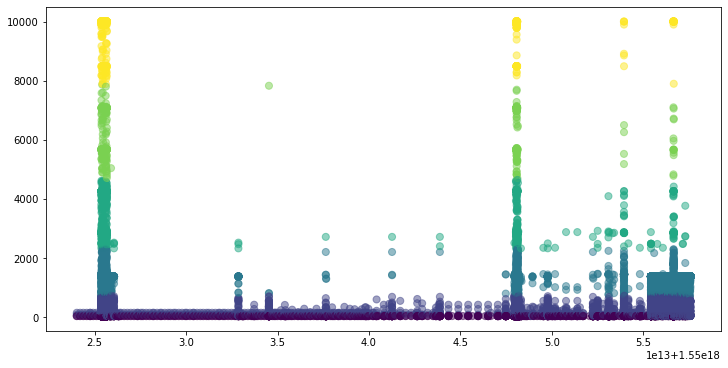

In [472]:
gvf = 0.0
nclasses = 2
X = df['Length'].to_numpy()
while gvf < 0.9:
    gvf = goodness_of_variance_fit(X, nclasses)
    nclasses += 1

X = df['Length'].to_numpy()

lims = jenks_breaks(X, nclasses)
df['Label'] = df['Length'].apply(lambda x: put_to_cluster(x, lims))

fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(10, 5))

plt.scatter(df['Time'], df['Length'], c= df['Label'], s=50, alpha=0.5)
plt.show()

In [473]:
res = []
res_size = len(df.index)/10
stream_weight = 1

In [474]:
i = 0
for index, row in df.iterrows():
    obj = (row['Time'], row['Length'], row['Label'])
    if i < res_size:
        key = np.random.rand()**(1/stream_weight)
        res += [(key,obj)]
    else:
        res_keys = [k for k,v in res]
        thresh = min(res_keys)
        min_ind = res_keys.index(thresh)
        key = np.random.rand()**(1/stream_weight)
        if key > thresh:
            res[min_ind] = (key,obj)
    i += 1

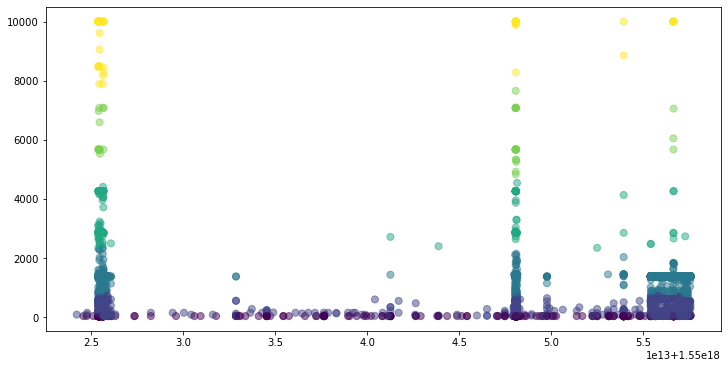

In [475]:
res_val = [v for k,v in res]
df2 = pd.DataFrame(res_val, columns=['Time', 'Length', 'Label'])
fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(10, 5))
plt.scatter(df2['Time'], df2['Length'], c= df2['Label'], s=50, alpha=0.5)

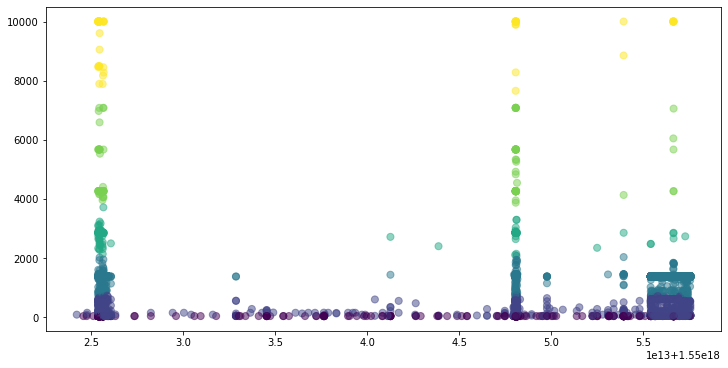

In [476]:

gvf = 0.0
nclasses = 2
X = df2['Length'].to_numpy()
while gvf < 0.9:
    gvf = goodness_of_variance_fit(X, nclasses)
    nclasses += 1

lims = jenks_breaks(X, nclasses)
df2['Label2'] = df2['Length'].apply(lambda x: put_to_cluster(x, lims))

fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(10, 5))

plt.scatter(df2['Time'], df2['Length'], c= df2['Label2'], s=50, alpha=0.5)
plt.show()

In [477]:
def stream_samp(samps: dict, order: int, L: int):
    if len(samps[order]) > L:
        hi_ord = order+1
        if hi_ord not in samps:
            samps[hi_ord] = []
        samp1 = samps[order].pop(0)
        samp2 = samps[order].pop(0)
        re_samp = random.sample(samp1, int(len(samp1)/2))
        re_samp += random.sample(samp2, int(len(samp2)/2))
        samps[hi_ord].append(re_samp)
        samps = stream_samp(samps, hi_ord, L)
    return samps

In [501]:
alpha = 0.3
L = int(len(df)/500)
T = int(len(df)/5000)

samps = {0:[[]]}

i = 0
for index, row in df.iterrows():
    obj = (row['Time'], row['Length'], row['Label'])
    if np.random.rand() < alpha:
        samps[0][-1].append(obj)
        if len(samps[0][-1]) > T:
            samps[0].append([])
            samps[0][-1].append(samps[0][-2].pop())
            samps = stream_samp(samps, 0, L)
    i+=1

In [502]:
samp_list = []

prob_dist = []

for k,v in samps.items():
    for i in range(len(samps[k])):
        samp_list += samps[k][i]
        prob_dist += [2**k]*len(samps[k][i])
                    
prob_dist = [i/sum(prob_dist) for i in prob_dist]

fin_ind = np.random.choice([i for i in range(len(samp_list))], size=min(int(len(df)/10),len(samp_list)), replace=False,p=prob_dist)
fin_ind = fin_ind.tolist()
fin_samp = [samp_list[i] for i in fin_ind]

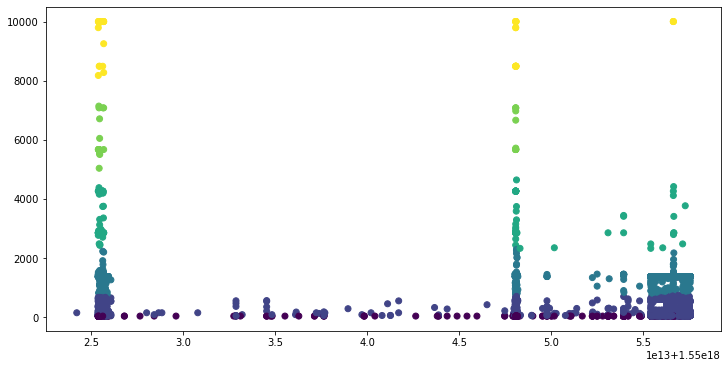

In [503]:
df3 = pd.DataFrame(fin_samp, columns=['Time', 'Length', 'Label'])
fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(10, 5))
plt.scatter(df3['Time'], df3['Length'], c= df3['Label'])

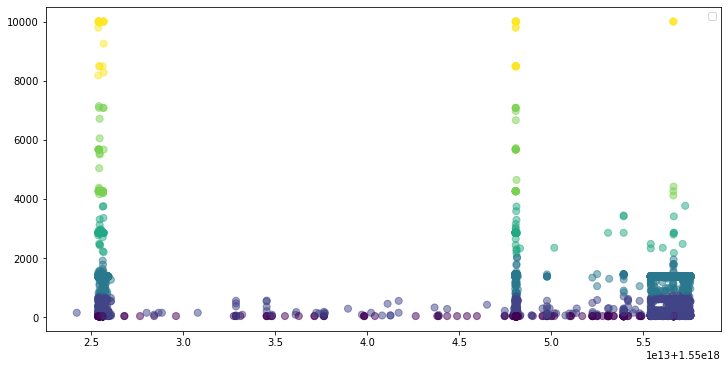

In [518]:
gvf = 0.0
nclasses = 2
X = df3['Length'].to_numpy()
while gvf < 0.9:
    gvf = goodness_of_variance_fit(X, nclasses)
    nclasses += 1

lims = jenks_breaks(X, nclasses)
df3['Label2'] = df3['Length'].apply(lambda x: put_to_cluster(x, lims))

fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(10, 5))

plt.scatter(df3['Time'], df3['Length'], c= df3['Label2'], s=50, alpha=0.5)
plt.show()

In [508]:
len(df2[df2['Label'] != df2['Label2']])

75

In [505]:
len(df3[df3['Label'] != df3['Label2']])

42

In [554]:
#F-measure for weighted reservoir
c = dict()
c_new = dict()


for index, row in df2.iterrows():
    if row['Label'] not in c:
        c[row['Label']] = 0
    c[row['Label']] = c[row['Label']] + 1
    if row['Label2'] not in c_new:
        c_new[row['Label2']] = 0
    c_new[row['Label2']] = c_new[row['Label2']] + 1
    
f = []
for k,v in c.items():
    f += [c[k] * (2 * c[k] * c_new[k])/(c[k] + c_new[k])]

In [555]:
sum(f)/len(f)

33547344.583363667

In [557]:
#F-measure for StreamSamp
c = dict()
c_new = dict()


for index, row in df3.iterrows():
    if row['Label'] not in c:
        c[row['Label']] = 0
    c[row['Label']] = c[row['Label']] + 1
    if row['Label2'] not in c_new:
        c_new[row['Label2']] = 0
    c_new[row['Label2']] = c_new[row['Label2']] + 1
    
f = []
for k,v in c.items():
    f += [c[k] * (2 * c[k] * c_new[k])/(c[k] + c_new[k])]

In [558]:
sum(f)/len(f)

34886679.16277439